# Packages import and plot settings

In [1]:
#Package import
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Progress bar
from tqdm.auto import tqdm

# Helper files
import helpers

In [2]:
#Settings for the plots 
sns.set_style("ticks")
colors= sns.color_palette('colorblind')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=13)
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.minor.size'] = 6

sns.set_style("darkgrid", {'axes.grid' : False, 'ytick.left': True, 'xtick.bottom': True})

# Clean data

In [3]:
#Read the merged data 
X_train_merged = pd.read_csv("project-data-merged/df_X_train.csv", index_col=0) #Nan and  -999
y_train_merged = pd.read_csv("project-data-merged/df_y_train.csv", index_col=0)

X_val_merged = pd.read_csv("project-data-merged/df_X_val.csv", index_col=0) #no Nan but -999
y_val_merged = pd.read_csv("project-data-merged/df_y_val.csv", index_col=0)  

X_test_merged = pd.read_csv("project-data-merged/df_X_test.csv", index_col=0) #no Nan but -999

In [4]:
#remove columns that have the -999 (Magnitude, distace closest and lowest usable frequency)
col_to_erase = ['magnitude','distance_closest','lowest_usable_frequency']

X_train_drop = X_train_merged.drop(columns = col_to_erase)
#display(X_train_3drop)

X_val_drop = X_val_merged.drop(columns = col_to_erase)
#display(X_val_3drop)

X_test_drop = X_test_merged.drop(columns = col_to_erase)
#display(X_test_3drop)
                        

In [5]:
#Remove -999
X_train_red, y_train_red = helpers.check_corrupted(X_train_drop, y_train_merged, 'Training')
X_val_red, y_val_red = helpers.check_corrupted(X_val_drop, y_val_merged, 'Validation')
X_test_nn = X_test_drop.drop(index=X_test_drop.columns[X_test_drop.eq(-999).any(axis=0)== True])

Training:
There are no -999 rows to remove 

Validation:
There are no -999 rows to remove 



In [6]:
#Remove Nan
X_train_nn, y_train_nn = helpers.check_Nan(X_train_red, y_train_red, 'Training')
X_val_nn, y_val_nn = helpers.check_Nan(X_val_red, y_val_red, 'Validation')

Training:
113705 (97.07 %) rows have Nan values and are removed
Validation:
There are no Nan rows to remove 



In [7]:
#define the train data as a PyTorch tensor
X_train_final = helpers.numpy_converter(X_train_nn)
y_train_final = helpers.numpy_converter(y_train_nn)

X_val_final = helpers.numpy_converter(X_val_nn)
y_val_final = helpers.numpy_converter(y_val_nn)

X_test_final = helpers.numpy_converter(X_test_nn)

In [8]:
n_zeros = np.count_nonzero(y_train_final==0)
n_ones = np.count_nonzero(y_train_final==1)


print("Number of 0 in train dataset: {} ".format(n_zeros))
print("Number of 1 in train dataset: {} ".format(n_ones))

Number of 0 in train dataset: 2208 
Number of 1 in train dataset: 1223 


In [9]:
#Normalize
X_train_final = helpers.normalize(X_train_final, X_train_final.mean(axis=0), X_train_final.std(axis=0))

X_val_final = helpers.normalize(X_val_final, X_train_final.mean(axis=0), X_train_final.std(axis=0))

X_test_final = helpers.normalize(X_test_final, X_train_final.mean(axis=0), X_train_final.std(axis=0))

In [10]:
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)
print(y_train_final.shape)
print(y_val_final.shape)

(3431, 112)
(2512, 112)
(48352, 112)
(3431, 1)
(2512, 1)


# Neural Net

In [11]:
#Hyper-parameters
epochs = 400
batch_size = 64
lr = 0.005

In [12]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data): #for initialization operations (reading and preprocess data)
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):  #returns data in batches
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

#Initialize the TrainData object (use Tensor type inputs)
train_data = TrainData(torch.FloatTensor(X_train_final), torch.FloatTensor(y_train_final))

In [13]:
class ValData(Dataset):
    def __init__(self, X_data, y_data): #for initialization operations (reading and preprocess data)
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):  #returns data in batches
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

#Initialize the TrainData object (use Tensor type inputs)
val_data = ValData(torch.FloatTensor(X_val_final), torch.FloatTensor(y_val_final))

In [14]:
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
test_data = TestData(torch.FloatTensor(X_test_final))

In [15]:
#Dataloader used to read data in batches
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(dataset=val_data, batch_size=X_val_final.shape[0], shuffle=True)
#val_loader = DataLoader(dataset=val_data, batch_size=1, shuffle=True)

test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)


#inizializazzione
#optimization hyperparameters
#Softmax
#optimizer ttrheshlodn
#changer groundtruth

In [16]:
class Model(nn.Module):

    def __init__(self):

        super(Model, self).__init__()
        self.l1 = nn.Linear(X_train_final.shape[1], 50)
        self.l2 = nn.Linear(50, 1)
        #self.l3 = nn.Linear(80, 1)
        self.Relu = nn.ReLU()

    def forward(self, x):
    
        out1 = self.Relu(self.l1(x))
        #out2 = self.Relu(self.l2(out1))
        y_pred = self.l2(out1)
        return y_pred
    
model = Model()

#check if GPU active 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
#Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr , weight_decay=0.03)

#move model on the GPU if active
model.to(device)

Model(
  (l1): Linear(in_features=112, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=1, bias=True)
  (Relu): ReLU()
)

In [18]:
def b_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

# Train

In [19]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int):
    model.train()
    
    accs_train = []
    losses_train = []
    
    accs_val = []
    losses_val = []
    
    for e in range(1, epochs+1):
        epoch_loss_train = 0
        epoch_acc_train = 0
        
        epoch_loss_val = 0
        epoch_acc_val = 0
        
        #TRAINING LOOP FOR EACH EPOCH
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            acc_train = b_acc(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()
            epoch_acc_train += acc_train.item()

        #np.append(losses_train,epoch_loss_train/len(train_loader))
        #np.append(accs_train,epoch_loss_train/len(train_loader))
        losses_train.append(epoch_loss_train/len(train_loader))
        accs_train.append(epoch_acc_train/len(train_loader))
        
    
        #VALIDATION LOOP FOR EACH EPOCH
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_val_pred = model(X_batch)

                loss_val = criterion(y_val_pred, y_batch)
                acc_val = b_acc(y_val_pred, y_batch)

                epoch_loss_val += loss_val.item()
                epoch_acc_val += acc_val.item()

            losses_val.append(epoch_loss_val/len(val_loader))
            accs_val.append(epoch_acc_val/len(val_loader))
            #np.append(losses_val,epoch_loss_train/len(val_loader))
            #np.append(accs_val,epoch_loss_train/len(val_loader))
            
        
        #print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss_train/len(train_loader):.5f} | Train Acc: {epoch_acc_train/len(train_loader):.3f}')
    return losses_train, accs_train, losses_val, accs_val

In [20]:
loss_train, acc_train, loss_val, acc_val =  train(model,val_loader,train_loader,criterion,optimizer,epochs)

Text(0, 0.5, 'Loss')

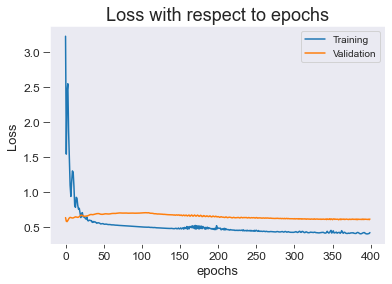

In [21]:
fig1=plt.figure()
plt.title('Loss with respect to epochs')
plt.plot(loss_train)
plt.plot(loss_val)
plt.legend(['Training', 'Validation'])
plt.xlabel('epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

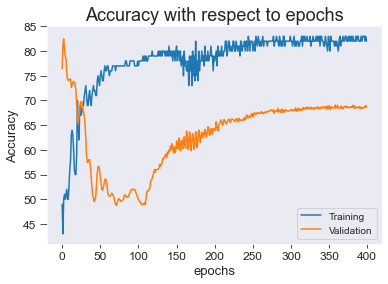

In [22]:
fig2=plt.figure()
plt.title('Accuracy with respect to epochs')
plt.plot(acc_train)
plt.plot(acc_val)
plt.legend(['Training', 'Validation'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')

# Validation

In [23]:
def validation (model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    
        with torch.no_grad():
            for X_batch , y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_val_pred = model(X_batch)

            val_acc = b_acc(y_val_pred,y_batch)
        return y_val_pred, val_acc

In [24]:
y_pred_val, val_acc=validation(model,val_loader)
print(val_acc)
print(y_pred_val.shape)

tensor(82.)
torch.Size([2512, 1])


# Test

In [25]:
def test(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    model.eval()
        
    y_pred_test = [] #initialize vector with predictions
   
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_test.append(y_pred_tag.cpu().numpy())

    y_pred_test = [int(a.squeeze().tolist()) for a in y_pred_test]
    return y_pred_test

In [26]:
label=pd.DataFrame(test(model,test_loader))
label.columns = ["label"]
label.to_csv("out_raf/label.csv", index = False, header = True)

In [27]:
#display(label)
count0 = (label['label'] == 0).sum()
count1 = (label['label'] == 1).sum()
print("Number of predicted 0 is: {} ".format(count0))
print("Number of predicted 1 is: {} ".format(count1))

Number of predicted 0 is: 29055 
Number of predicted 1 is: 19297 
